In [2]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
# Dataset config
TIME_BEG = 1451606420 # = year 2016
# TIME_BEG = 1546347600 # = year 2019
TIME_INTERVAL = 30 # minutes
LEN_ENCODE_SERIE = 48
LEN_DECODE_SERIE = 1

In [4]:
# Read csv file
prices = None
with open('kaggle_1min.csv', 'r') as f:
    reader = csv.reader(f)
    prices = list(reader)

In [5]:
# Process with Panda dataframe
prices_df = pd.DataFrame(prices[1:], columns=prices[0])
print("Original dataframe: ", prices_df)

prices_df = prices_df.drop(columns=["Volume_(Currency)"])
prices_df = prices_df.astype(float)
prices_df = prices_df.fillna(0) # Replace NaN with 0 (time where trade volume = 0)
prices_df = prices_df.loc[prices_df["Timestamp"] >= TIME_BEG] # Cut off from desired begin time
prices_df = prices_df.reset_index(drop=True)

# Make col name to index map
cols = prices_df.columns
col_i = dict()
for i in range(len(cols)):
    col_i[cols[i]] = i

print("Processed dataframe: ", prices_df)

Original dataframe:            Timestamp      Open      High       Low     Close Volume_(BTC)  \
0        1325317920      4.39      4.39      4.39      4.39   0.45558087   
1        1325317980       NaN       NaN       NaN       NaN          NaN   
2        1325318040       NaN       NaN       NaN       NaN          NaN   
3        1325318100       NaN       NaN       NaN       NaN          NaN   
4        1325318160       NaN       NaN       NaN       NaN          NaN   
...             ...       ...       ...       ...       ...          ...   
4727772  1609372560  28801.47  28829.42  28785.64  28829.42   0.96522104   
4727773  1609372620  28829.42   28863.9  28829.42  28857.06   2.36883117   
4727774  1609372680  28850.49  28900.52  28850.49  28882.82   2.46658976   
4727775  1609372740  28910.54  28911.52   28867.6   28881.3     7.332773   
4727776  1609372800  28893.21  28928.49  28893.21  28928.49   5.75767938   

        Volume_(Currency) Weighted_Price  
0            2.00000001

In [6]:
print(col_i)

{'Timestamp': 0, 'Open': 1, 'High': 2, 'Low': 3, 'Close': 4, 'Volume_(BTC)': 5, 'Weighted_Price': 6}


In [7]:
# Convert dataframe to torch tensor
prices_tensor = torch.from_numpy(prices_df.values)

In [8]:
# Fill values for timesteps with 0 trade volume
for i in range(0, len(prices_tensor)):
    if prices_tensor[i, col_i["Volume_(BTC)"]] == 0:
        prices_tensor[i, col_i["Open"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Close"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["High"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Low"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Weighted_Price"]] = prices_tensor[i-1, col_i["Close"]]

In [9]:
# Summarize data by each TIME_INTERVAL, use Volume Weighted Average Price (VWAP)
num_data = prices_tensor.shape[0] // TIME_INTERVAL
shape = (num_data, 7)
condensed_prices_tensor = torch.empty(shape)

j = 0
i = 0
while i <= len(prices_tensor) - TIME_INTERVAL:
    condensed_prices_tensor[j, col_i["Timestamp"]] = prices_tensor[i, col_i["Timestamp"]] # Time stamp

    # Calculate WVAP
    volume_weighted_sum = torch.sum(prices_tensor[i:i+TIME_INTERVAL, col_i["Volume_(BTC)"]] * prices_tensor[i:i+TIME_INTERVAL, col_i["Weighted_Price"]])
    total_volume = torch.sum(prices_tensor[i:i+TIME_INTERVAL, col_i["Volume_(BTC)"]])
    wvap = volume_weighted_sum / total_volume
    
    # If no trade in this time interval use the price in the previous one
    # Here assume that first TIME_INTERVAL starting from TIME_BEG has non-zero trade volume
    if total_volume == 0:
        condensed_prices_tensor[j, col_i["Weighted_Price"]] = condensed_prices_tensor[j-1, col_i["Weighted_Price"]]
    else:
        condensed_prices_tensor[j, col_i["Weighted_Price"]] = wvap
        
    # Store volume
    condensed_prices_tensor[j, col_i["Open"]] = prices_tensor[i, col_i["Open"]] # Open price 
    condensed_prices_tensor[j, col_i["High"]] = torch.max(prices_tensor[i:i+TIME_INTERVAL, col_i["High"]]) # Highest price
    condensed_prices_tensor[j, col_i["Close"]] = prices_tensor[i+TIME_INTERVAL-1, col_i["Close"]] # Close price
    condensed_prices_tensor[j, col_i["Low"]] = torch.min(prices_tensor[i:i+TIME_INTERVAL, col_i["Low"]]) # Lowest price
    condensed_prices_tensor[j, col_i["Volume_(BTC)"]] = total_volume

#     if condensed_prices_tensor[j, col_i["Volume_(BTC)"]] == 0:
#         print()
#         print(condensed_prices_tensor[j])
    
    j += 1
    i += TIME_INTERVAL

Original price data shape:  torch.Size([2629440, 7])
Time condensed price data shape:  torch.Size([87648, 7])
Condensed price data: 
 tensor([[1.4516e+09, 4.3089e+02, 4.3258e+02,  ..., 4.3146e+02, 2.0609e+01,
         4.3169e+02],
        [1.4516e+09, 4.3239e+02, 4.3240e+02,  ..., 4.3174e+02, 2.3045e+01,
         4.3129e+02],
        [1.4516e+09, 4.3201e+02, 4.3201e+02,  ..., 4.3123e+02, 1.7243e+01,
         4.3018e+02],
        ...,
        [1.6094e+09, 2.8885e+04, 2.8899e+04,  ..., 2.8728e+04, 1.4369e+02,
         2.8766e+04],
        [1.6094e+09, 2.8746e+04, 2.8890e+04,  ..., 2.8859e+04, 7.8922e+01,
         2.8781e+04],
        [1.6094e+09, 2.8870e+04, 2.8937e+04,  ..., 2.8928e+04, 6.3739e+01,
         2.8877e+04]])
Timestamp
Max Timestamp 1609371008.0
Min Timestamp 1451606400.0
Mean Timestamp 1530487808.0
Standard deviation Timestamp 45543496.0

Open
Max Open 28942.83984375
Min Open 355.760009765625
Mean Open 6080.310546875
Standard deviation Open 4661.89306640625

High
Max High 2

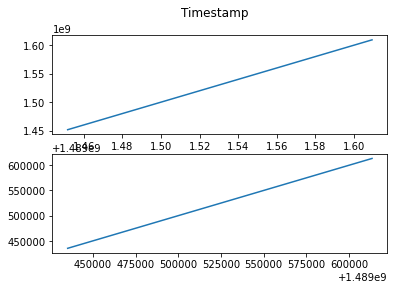

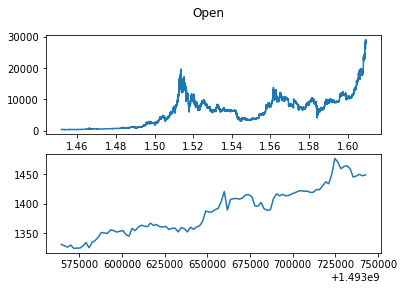

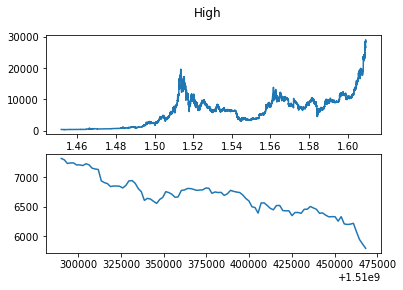

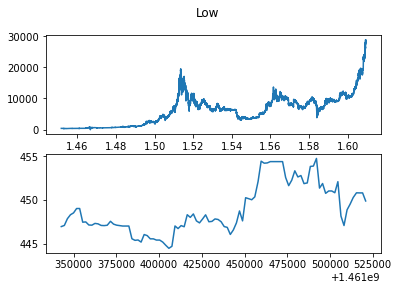

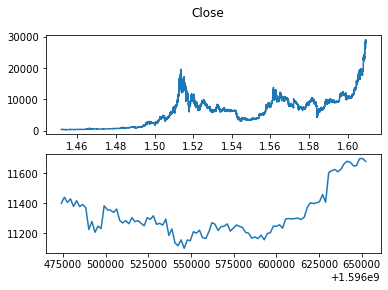

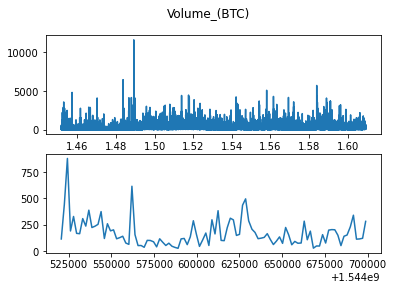

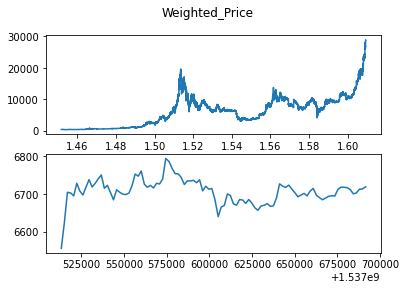

In [10]:
DISPLAY_SECTION_LEN = 100

# Data summary and visualization
print("Original price data shape: ", prices_tensor.shape)
print("Time condensed price data shape: ", condensed_prices_tensor.shape)
print("Condensed price data: \n", condensed_prices_tensor)

for col_name in col_i:
    ind = col_i[col_name]
    x = condensed_prices_tensor[:, 0] # Time
    y = condensed_prices_tensor[:, ind]
    
    # Random section for zoomed in view
    rand_sec_i = random.randint(0, len(condensed_prices_tensor) - DISPLAY_SECTION_LEN)

    fig, axs = plt.subplots(2)
    fig.suptitle(col_name)
    axs[0].plot(x, y)
    axs[1].plot(x[rand_sec_i:rand_sec_i+DISPLAY_SECTION_LEN], y[rand_sec_i:rand_sec_i+DISPLAY_SECTION_LEN])

    mini = torch.min(condensed_prices_tensor[:,ind]).item()
    maxi = torch.max(condensed_prices_tensor[:,ind]).item()
    mean = torch.mean(condensed_prices_tensor[:,ind]).item()
    std = torch.std(condensed_prices_tensor[:,ind]).item()

    print(col_name)
    print("Max", col_name, maxi)
    print("Min", col_name, mini)
    print("Mean", col_name, mean)
    print("Standard deviation", col_name, std)
    print()

tensor([ -9.2149, -25.6091,  -1.7983,  13.4876,  -0.3869,  12.9441,  32.9607,
         34.4472,  17.2488,   5.6791,   4.3314, -70.2420,  30.4381,  47.4401,
        -22.4694, -64.5120,  39.4805, -23.0395, -26.2738,   1.4253])
Max 2359.098876953125
Min -1634.5233154296875
Mean 0.6250631213188171
Standard deviation 53.94206619262695
percentile_lowest -21.783487319946286
percentile_lower -4.461066818237303
percentile_higher 6.6159004211425785
percentile_highest 24.279329681396487


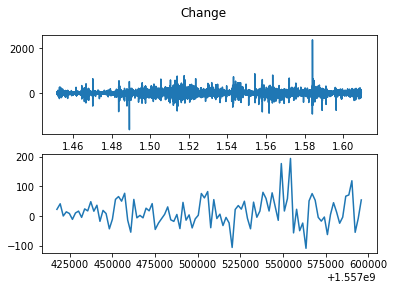

In [38]:
# Convert price to change in price in one ten thousanth
price_change = (condensed_prices_tensor[1:, col_i["Weighted_Price"]] - condensed_prices_tensor[:-1, col_i["Weighted_Price"]]) / condensed_prices_tensor[:-1, col_i["Weighted_Price"]]
price_change *= 10000

mini = torch.min(price_change).item()
maxi = torch.max(price_change).item()
mean = torch.mean(price_change).item()
std = torch.std(price_change).item()
percentile_lowest = np.percentile(price_change.numpy(), 20).item()
percentile_lower = np.percentile(price_change.numpy(), 40).item()
percentile_higher = np.percentile(price_change.numpy(), 60).item()
percentile_highest = np.percentile(price_change.numpy(), 80).item()

print(price_change[:20])
print("Max", maxi)
print("Min", mini)
print("Mean", mean)
print("Standard deviation", std)
print("percentile_lowest", percentile_lowest)
print("percentile_lower", percentile_lower)
print("percentile_higher", percentile_higher)
print("percentile_highest", percentile_highest)

time_x = condensed_prices_tensor[1:, 0]
price_change_y = price_change
section_start = random.randint(0, len(price_change) - DISPLAY_SECTION_LEN)

fig, axs = plt.subplots(2)
fig.suptitle('Change')
axs[0].plot(time_x, price_change_y)
axs[1].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], price_change_y[section_start:section_start+DISPLAY_SECTION_LEN])


In [19]:
# Convert candle stat to percentage of vwap
candle_stats = condensed_prices_tensor[1:, 1:5] / condensed_prices_tensor[1:, col_i["Weighted_Price"]].reshape(-1, 1)

tensor([[1.4516e+09, 4.3089e+02, 4.3258e+02, 4.3019e+02, 4.3146e+02, 2.0609e+01,
         4.3169e+02],
        [1.4516e+09, 4.3239e+02, 4.3240e+02, 4.2982e+02, 4.3174e+02, 2.3045e+01,
         4.3129e+02],
        [1.4516e+09, 4.3201e+02, 4.3201e+02, 4.2908e+02, 4.3123e+02, 1.7243e+01,
         4.3018e+02],
        [1.4516e+09, 4.3137e+02, 4.3137e+02, 4.2935e+02, 4.3001e+02, 1.1636e+01,
         4.3011e+02],
        [1.4516e+09, 4.3001e+02, 4.3169e+02, 4.3000e+02, 4.3140e+02, 8.5132e+00,
         4.3069e+02]])
tensor([[1.0026, 1.0026, 0.9966, 1.0010],
        [1.0042, 1.0042, 0.9974, 1.0024],
        [1.0029, 1.0029, 0.9982, 0.9998],
        [0.9984, 1.0023, 0.9984, 1.0017],
        [1.0022, 1.0023, 0.9987, 0.9998]])


In [16]:
# Checking for nan data
assert(torch.sum(price_change != price_change) == 0)

tensor([[ 0,  1,  2],
        [-1,  0,  1],
        [-1,  0,  1]])


Max 43.97739791870117
Min -30.219829559326172
Mean 4.526435670726414e-09
Standard deviation 1.0
percentile_lowest -0.4129880666732788
percentile_lower -0.09464444667100906
percentile_higher 0.11127630770206451
percentile_highest 0.4382464945316315


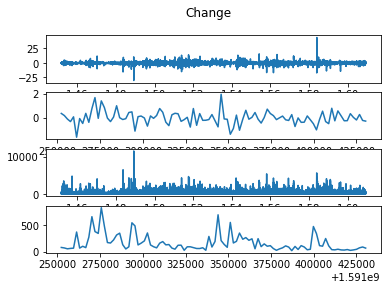

In [35]:
# # Normalize
# price_change = (price_change - mean) / std

# mini = torch.min(price_change).item()
# maxi = torch.max(price_change).item()
# mean = torch.mean(price_change).item()
# std = torch.std(price_change).item()

# print("Max", maxi)
# print("Min", mini)
# print("Mean", mean)
# print("Standard deviation", std)

# price_change = torch.cat([price_change.unsqueeze(1), condensed_prices_tensor[1:, 2].unsqueeze(1)], dim=1)

# time_x = condensed_prices_tensor[1:, 0]
# price_change_y = price_change[:, 0]
# volume_y = price_change[:, 1] 
# section_start = random.randint(0, len(price_change) - DISPLAY_SECTION_LEN)

# fig, axs = plt.subplots(4)
# fig.suptitle('Change')
# axs[0].plot(time_x, price_change_y)
# axs[1].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], price_change_y[section_start:section_start+DISPLAY_SECTION_LEN])
# axs[2].plot(time_x, volume_y)
# axs[3].plot(time_x[section_start:section_start+DISPLAY_SECTION_LEN], volume_y[section_start:section_start+DISPLAY_SECTION_LEN])


In [43]:
# Slap all features together!
# Open, High, Low, Close, Volume, Price change
price_change = price_change.reshape(-1, 1)
volumes = condensed_prices_tensor[1:, col_i["Volume_(BTC)"]].reshape(-1, 1)
data = torch.cat([candle_stats, volumes, price_change], dim=1)

In [44]:
# Make input time serie data and target time serie data tensor 
num_data = (len(data) - LEN_ENCODE_SERIE - LEN_DECODE_SERIE) // LEN_DECODE_SERIE + 1

X_shape = (num_data, LEN_ENCODE_SERIE, len(data[0]))
y_shape = (num_data, LEN_DECODE_SERIE)

X, y = torch.empty(X_shape), torch.empty(y_shape)

for i in range(num_data):
    start = i * LEN_DECODE_SERIE
    X[i] = data[start:start+LEN_ENCODE_SERIE]
    y[i] = data[start+LEN_ENCODE_SERIE:start+LEN_ENCODE_SERIE+LEN_DECODE_SERIE, -1] # Price is last feature


In [45]:
# print(y)
# y = (y > percentile_highest).float() + (y > percentile_higher).float() + (y > percentile_lower).float() + (y > percentile_lowest).float() - 2
# y = (y > percentile_higher).float() + (y > percentile_lower).float() - 1
print(y)


tensor([[  3.5695],
        [-13.3130],
        [-51.0547],
        ...,
        [-27.3964],
        [  5.0855],
        [ 33.5667]])


In [47]:
print("Encode time serie data shape:", X_shape)
print("Decode time serie data shape:", y_shape)
print("Training X:\n", X)
print("Training y:\n", y)

Encode time serie data shape: (87599, 48, 6)
Decode time serie data shape: (87599, 1)
Training X:
 tensor([[[  1.0026,   1.0026,   0.9966,   1.0010,  23.0452,  -9.2149],
         [  1.0042,   1.0042,   0.9974,   1.0024,  17.2432, -25.6091],
         [  1.0029,   1.0029,   0.9982,   0.9998,  11.6362,  -1.7983],
         ...,
         [  0.9978,   1.0014,   0.9978,   1.0014,  34.3647,  26.6713],
         [  1.0024,   1.0024,   0.9974,   1.0022,  51.5058, -10.3598],
         [  0.9995,   1.0020,   0.9984,   1.0014, 287.9370,  27.2462]],

        [[  1.0042,   1.0042,   0.9974,   1.0024,  17.2432, -25.6091],
         [  1.0029,   1.0029,   0.9982,   0.9998,  11.6362,  -1.7983],
         [  0.9984,   1.0023,   0.9984,   1.0017,   8.5132,  13.4876],
         ...,
         [  1.0024,   1.0024,   0.9974,   1.0022,  51.5058, -10.3598],
         [  0.9995,   1.0020,   0.9984,   1.0014, 287.9370,  27.2462],
         [  0.9989,   1.0017,   0.9969,   0.9982, 145.0244,   3.5695]],

        [[  1.002

In [48]:
torch.save(X, "./../X.pt")
torch.save(y, "./../y.pt")